## Imports

In [1]:
import json

from fastai.tabular.all import *
from fastai.collab import *
from IPython.display import display
from sklearn.neighbors import NearestNeighbors

## Load Kaggle data

In [2]:
# Load and clean games data
df_games = pd.read_csv("kaggle/games_detailed_info.csv")
df_games = df_games[[
    "id",
    "primary",
    "yearpublished",
    "minplayers",
    "maxplayers",
    "minage",
    "playingtime",
    "image",
    "thumbnail",
    "average",
    "usersrated",
    "boardgamecategory"
]]
df_games = df_games.dropna()
df_games = df_games.rename(columns={
    "id": "bgg_id",
    "primary": "name",
    "yearpublished": "year",
    "minplayers": "min_players",
    "maxplayers": "max_players",
    "minage": "min_age",
    "playingtime": "playing_time",
    "image": "image_url",
    "thumbnail": "thumbnail_url",
    "average": "average_rating",
    "usersrated": "ratings_count",
    "boardgamecategory": "categories",
})

df_games["bgg_id"] = df_games["bgg_id"].astype('int32')
df_games["name"] = df_games["name"].astype('string')
df_games["year"] = df_games["year"].astype('int32')
df_games["min_players"] = df_games["min_players"].astype('int32')
df_games["max_players"] = df_games["max_players"].astype('int32')
df_games["playing_time"] = df_games["playing_time"].astype('int32')
df_games["min_age"] = df_games["min_age"].astype('int32')
df_games["categories"] = df_games["categories"].astype('string')
df_games["thumbnail_url"] = df_games["thumbnail_url"].astype('string')
df_games["image_url"] = df_games["image_url"].astype('string')
df_games = df_games.sort_values("bgg_id")

df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21334 entries, 671 to 19652
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bgg_id          21334 non-null  int32  
 1   name            21334 non-null  string 
 2   year            21334 non-null  int32  
 3   min_players     21334 non-null  int32  
 4   max_players     21334 non-null  int32  
 5   min_age         21334 non-null  int32  
 6   playing_time    21334 non-null  int32  
 7   image_url       21334 non-null  string 
 8   thumbnail_url   21334 non-null  string 
 9   average_rating  21334 non-null  float64
 10  ratings_count   21334 non-null  int64  
 11  categories      21334 non-null  string 
dtypes: float64(1), int32(6), int64(1), string(4)
memory usage: 1.6 MB


/var/folders/sh/cbmhd8vj47d56w5zqfylwrmr0000gn/T/ipykernel_80398/3307977718.py:2: DtypeWarning: Columns (29,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_games = pd.read_csv("kaggle/games_detailed_info.csv")


In [3]:
# Load and clean reviews
df_reviews = pd.read_csv("kaggle/bgg-19m-reviews.csv")
df_reviews = df_reviews[["ID", "user", "rating"]]
df_reviews = df_reviews.dropna()
df_reviews = df_reviews.rename(columns={
    "ID": "bgg_id",
    "rating": "rating",
    "user": "user"
})
df_reviews["user"] = df_reviews["user"].astype('string')
df_reviews['rating'] = round(df_reviews['rating'], 0)
df_reviews = df_reviews.sample(frac=1)

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18964741 entries, 11285156 to 7534283
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   bgg_id  int64  
 1   user    string 
 2   rating  float64
dtypes: float64(1), int64(1), string(1)
memory usage: 578.8 MB


In [4]:
# Exclude reviews for games without info
ids_from_games_df = df_games['bgg_id'].unique()
df_reviews = df_reviews[df_reviews['bgg_id'].isin(ids_from_games_df)]

# Exclude games without reviews
ids_from_reviews_df = df_reviews['bgg_id'].unique()
df_games = df_games[df_games['bgg_id'].isin(ids_from_reviews_df)]

# Assert IDs are the same
ids_from_games_df = df_games['bgg_id'].unique()
ids_from_reviews_df = df_reviews['bgg_id'].unique()
ids_from_games_df.sort()
ids_from_reviews_df.sort()
assert(list(ids_from_games_df) == list(ids_from_reviews_df))

## Collaborative filtering

In [5]:
dls = CollabDataLoaders.from_df(df_reviews, user_name='user', item_name='bgg_id', rating_name='rating', bs=100_000)
dls.show_batch()

,user,bgg_id,rating
0,Darth Fluffy,103886,7.0
1,kebullock,9209,8.0
2,Culvan,7182,3.0
3,kast80,37224,6.0
4,uveemebe,102680,7.0
5,honololo,171623,8.0
6,bliming1969,13,10.0
7,Bugchan,96848,8.0
8,Miki,2952,4.0
9,Primori,218417,8.0


SuggestedLRs(valley=0.009120108559727669)

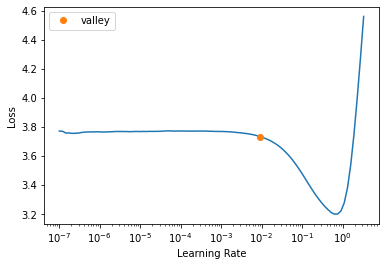

In [6]:
learner = collab_learner(dls, n_factors=50, y_range=(2.,10))
learner.lr_find()

In [7]:
epochs = 10
learning_rate = 0.005 # found with cf_model.lr_find()
learner.fit_one_cycle(epochs, learning_rate, wd=0.1)

epoch,train_loss,valid_loss,time
0,3.424771,3.162185,00:25
1,2.252027,1.897320,00:25
2,1.695592,1.632563,00:27
3,1.512116,1.548002,00:26
4,1.386765,1.511433,00:27
5,1.275081,1.497452,00:26
6,1.182074,1.495018,00:26
7,1.118073,1.496240,00:26
8,1.078134,1.497376,00:27
9,1.060284,1.497526,00:26


## Extract the most rated games

In [8]:
games_ids_sorted_by_rating = df_reviews.groupby('bgg_id')['rating'].count().sort_values(ascending=False).index.values[:1000]
top_thousand_game_ids = games_ids_sorted_by_rating[:1000]

def bgg_ids_to_game_df(ids):
    return pd.DataFrame(ids, columns=["bgg_id"]).join(df_games.set_index("bgg_id"), on="bgg_id")

bgg_ids_to_game_df(top_thousand_game_ids)[["bgg_id", "name", "average_rating", "ratings_count"]].head(5)

,bgg_id,name,average_rating,ratings_count
0,30549,Pandemic,7.58896,109006
1,822,Carcassonne,7.41837,108776
2,13,Catan,7.13598,108064
3,68448,7 Wonders,7.73515,90021
4,36218,Dominion,7.61000,81582


## Game bias

In [9]:
game_bias = learner.model.bias(top_thousand_game_ids, is_item=True)
game_bias.shape

torch.Size([1000])

In [10]:
mean_ratings = df_reviews.groupby('bgg_id')['rating'].mean()
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_thousand_game_ids, game_bias)]

Now let's have a look at the games with the worst bias

In [11]:
item0 = lambda o:o[0]
worst_bias_items = sorted(game_ratings, key=item0)[:15]
bgg_ids_to_game_df([worst_bias_item[1] for worst_bias_item in worst_bias_items])[["bgg_id", "name", "average_rating", "ratings_count"]]

,bgg_id,name,average_rating,ratings_count
0,5432,Chutes and Ladders,2.86623,4038
1,5048,Candy Land,3.18480,4239
2,3737,Operation,4.12166,3829
3,2921,The Game of Life,4.30772,11326
4,1406,Monopoly,4.37245,30817
5,2407,Sorry!,4.52150,6165
6,2425,Battleship,4.66067,9127
7,2136,Pachisi,4.49749,4768
8,5894,Twister,4.53733,4229
9,4143,Guess Who?,4.80090,5111


Now let's have a look at the games with the _best_ bias

In [12]:
best_bias_items = sorted(game_ratings, key=lambda o: o[0], reverse=True)[:15]
bgg_ids_to_game_df([best_bias_item[1] for best_bias_item in best_bias_items])[["bgg_id", "name", "average_rating", "ratings_count"]]

,bgg_id,name,average_rating,ratings_count
0,246900,Eclipse: Second Dawn for the Galaxy,8.67425,5388
1,266507,Clank!: Legacy – Acquisitions Incorporated,8.69588,4944
2,233078,Twilight Imperium: Fourth Edition,8.67603,16036
3,55690,Kingdom Death: Monster,8.60553,8068
4,314040,Pandemic Legacy: Season 0,8.63589,3574
5,115746,War of the Ring: Second Edition,8.51211,15508
6,316554,Dune: Imperium,8.32094,14949
7,224517,Brass: Birmingham,8.66343,25515
8,187645,Star Wars: Rebellion,8.42463,25603
9,291457,Gloomhaven: Jaws of the Lion,8.68168,15963


## Weights

In [13]:
game_weight = learner.model.weight(top_thousand_game_ids, is_item=True)
game_weight.shape

torch.Size([1000, 50])

In [14]:
game_pca = game_weight.pca(3)
print(game_pca.shape)
fac0, fac1, fac2 = game_pca.t()

torch.Size([1000, 3])


In [15]:
def show_best_and_worst_dim(fac):
    game_comp = [(f, i) for f,i in zip(fac, top_thousand_game_ids)]
    best_items = sorted(game_comp, key=itemgetter(0), reverse=True)[:10]
    worst_items = sorted(game_comp, key=itemgetter(0))[:10]

    print("Best for this dimension:")
    display(bgg_ids_to_game_df([item[1] for item in best_items])[["bgg_id", "name"]])

    print("Worst for this dimension")
    display(bgg_ids_to_game_df([item[1] for item in worst_items])[["bgg_id", "name"]])
    
show_best_and_worst_dim(fac0)

Best for this dimension:


,bgg_id,name
0,5432,Chutes and Ladders
1,5048,Candy Land
2,2921,The Game of Life
3,1406,Monopoly
4,2136,Pachisi
5,2407,Sorry!
6,1258,Phase 10
7,2471,Zombies!!!
8,258,Fluxx
9,3737,Operation


Worst for this dimension


,bgg_id,name
0,174430,Gloomhaven
1,224517,Brass: Birmingham
2,220308,Gaia Project
3,233078,Twilight Imperium: Fourth Edition
4,291457,Gloomhaven: Jaws of the Lion
5,184267,On Mars
6,162886,Spirit Island
7,251247,Barrage
8,182028,Through the Ages: A New Story of Civilization
9,193738,Great Western Trail


In [16]:
show_best_and_worst_dim(fac1)

Best for this dimension:


,bgg_id,name
0,42,Tigris & Euphrates
1,12,Ra
2,118,Modern Art
3,93,El Grande
4,4098,Age of Steam
5,503,Through the Desert
6,43015,Hansa Teutonica
7,215,Tichu
8,46,Medici
9,475,Taj Mahal


Worst for this dimension


,bgg_id,name
0,146021,Eldritch Horror
1,205059,Mansions of Madness: Second Edition
2,264220,Tainted Grail: The Fall of Avalon
3,167355,Nemesis
4,174430,Gloomhaven
5,55690,Kingdom Death: Monster
6,180263,The 7th Continent
7,12493,Twilight Imperium: Third Edition
8,15987,Arkham Horror
9,164153,Star Wars: Imperial Assault


In [17]:
show_best_and_worst_dim(fac2)

Best for this dimension:


,bgg_id,name
0,188,Go
1,483,Diplomacy
2,12333,Twilight Struggle
3,124742,Android: Netrunner
4,103343,A Game of Thrones: The Board Game (Second Edition)
5,171,Chess
6,12493,Twilight Imperium: Third Edition
7,121,Dune
8,25613,Through the Ages: A Story of Civilization
9,42,Tigris & Euphrates


Worst for this dimension


,bgg_id,name
0,266192,Wingspan
1,286096,Tapestry
2,244521,The Quacks of Quedlinburg
3,199561,Sagrada
4,183394,Viticulture Essential Edition
5,199792,Everdell
6,197376,Charterstone
7,274960,Point Salad
8,209685,Century: Spice Road
9,169426,Roll Player


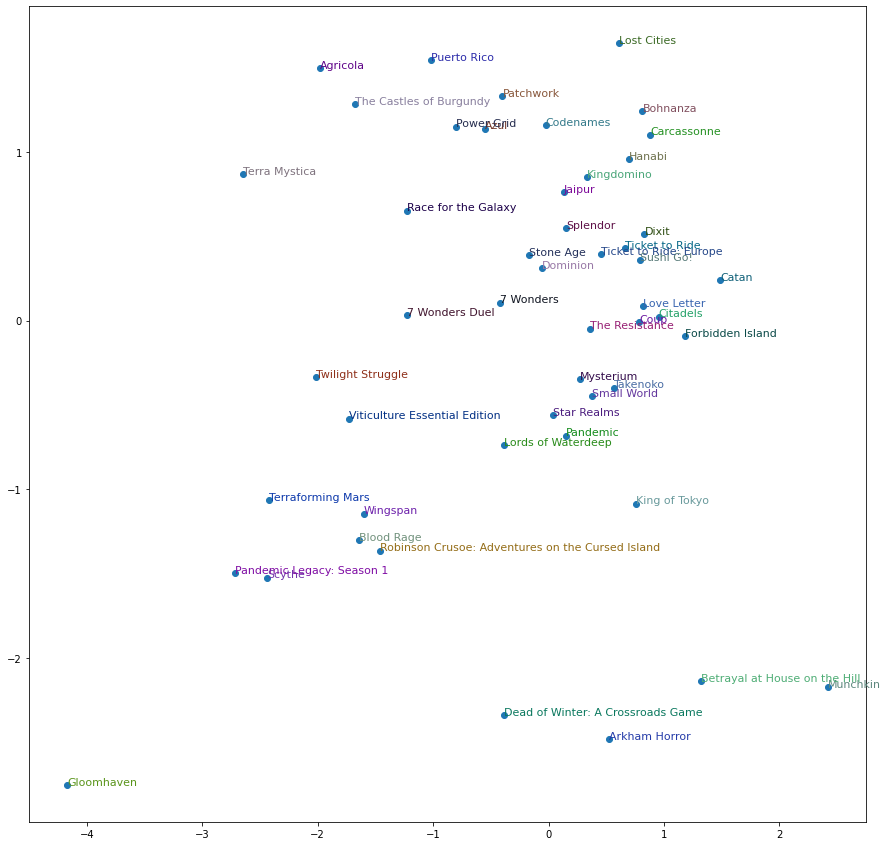

In [18]:
indices = np.random.choice(len(top_thousand_game_ids), 50, replace=False)
indices = list(range(50))

X = fac0[indices]
Y = fac1[indices]

plt.figure(figsize=(15,15))
plt.scatter(X, Y)

id_to_name_dict = df_games[["bgg_id", "name"]].set_index("bgg_id").to_dict('index')
for game_id, x, y in zip(top_thousand_game_ids[indices], X, Y):
    plt.text(
        x,
        y,
        id_to_name_dict[game_id]['name'],
        color=np.random.rand(3)*0.7,
        fontsize=11
    )

plt.show()

## Nearest neighbours

In [19]:
all_game_ids = df_reviews['bgg_id'].unique()
index_to_game_id_dict = {index:game_id for index, game_id in enumerate(all_game_ids)}
game_id_to_index_dict = {game_id:index for index, game_id in index_to_game_id_dict.items()}

weights = learner.model.weight(all_game_ids, is_item=True)
npweights = weights.numpy()
bias = learner.model.bias(all_game_ids, is_item=True)

nn = NearestNeighbors(n_neighbors=20) # 20 recs per key
fitnn = nn.fit(npweights)

In [20]:
games_for_test = ["Monopoly", "Splendor", "UNO"]
for game_name in games_for_test:
    display(df_games[df_games['name'] == game_name][["bgg_id", "name"]])

,bgg_id,name
68,1406,Monopoly


,bgg_id,name
11,148228,Splendor


,bgg_id,name
112,2223,UNO


In [21]:
def get_recommended_game_ids_from_game_id(game_id):
    w = npweights[game_id_to_index_dict[game_id]]
    print(game_id_to_index_dict[game_id])
    distances, indices = fitnn.kneighbors([w])
    return [index_to_game_id_dict[index] for index in indices[0]]

bgg_ids_to_game_df(get_recommended_game_ids_from_game_id(148228)).head(5)

107


,bgg_id,name,year,min_players,max_players,min_age,playing_time,image_url,thumbnail_url,average_rating,ratings_count,categories
0,148228,Splendor,2014,2,4,10,30,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-1-OFw__original/img/Y2tUGY2nPTGd_epJYKQXPkQD8AM=/0x0/filters:format(jpeg)/pic1904079.jpg,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-1-OFw__thumb/img/D4hkkHfOgu22PwgJomjplWAveuo=/fit-in/200x150/filters:strip_icc()/pic1904079.jpg,7.44000,64734,"['Card Game', 'Economic', 'Renaissance']"
1,209685,Century: Spice Road,2017,2,5,8,45,https://cf.geekdo-images.com/0_KEDk4lCvryf1Ju3YQJxA__original/img/zv58Iylm_N8nfVFgRkMVM0Q9Fh8=/0x0/filters:format(jpeg)/pic3339551.jpg,https://cf.geekdo-images.com/0_KEDk4lCvryf1Ju3YQJxA__thumb/img/FticvQmaT_qfdrX-hpSSK1ttRb0=/fit-in/200x150/filters:strip_icc()/pic3339551.jpg,7.35440,20396,"['Card Game', 'Economic', 'Medieval']"
2,232832,Century: Golem Edition,2017,2,5,8,45,https://cf.geekdo-images.com/1bihoShOuqaCuZJXB3Q2gQ__original/img/fvGzpqyud6Oz1BWOe4gItWWb8P0=/0x0/filters:format(jpeg)/pic3936124.jpg,https://cf.geekdo-images.com/1bihoShOuqaCuZJXB3Q2gQ__thumb/img/dvGQkdnwtcwAmcxHR_7J17OsLjQ=/fit-in/200x150/filters:strip_icc()/pic3936124.jpg,7.68962,8403,"['Card Game', 'Economic', 'Fantasy']"
3,148949,Istanbul,2014,2,5,10,60,https://cf.geekdo-images.com/PHH9Mreen2sBcxV6ZsE3ew__original/img/pHIJibqf-DmlOQD3CfT_rAjGmc0=/0x0/filters:format(jpeg)/pic1885326.jpg,https://cf.geekdo-images.com/PHH9Mreen2sBcxV6ZsE3ew__thumb/img/Vzpg3sdeAbCy0IxSAoh1aH9nvDE=/fit-in/200x150/filters:strip_icc()/pic1885326.jpg,7.56871,27086,['Economic']
4,192291,Sushi Go Party!,2016,2,8,8,20,https://cf.geekdo-images.com/2f9uTicUSXkdPp2Yks6zFw__original/img/WQcFmlhYBMIp8f6gNNVhnnue1w4=/0x0/filters:format(jpeg)/pic5885689.jpg,https://cf.geekdo-images.com/2f9uTicUSXkdPp2Yks6zFw__thumb/img/_mXR9Tlo0f-i80h6pfhDEOBgvpY=/fit-in/200x150/filters:strip_icc()/pic5885689.jpg,7.44587,25871,"['Card Game', 'Party Game']"


In [22]:
def get_recommended_game_ids_from_game_ids(game_ids):
    weights = [
        npweights[game_id_to_index_dict[game_id]]
        for game_id in game_ids
    ]
    distances, indices = fitnn.kneighbors(weights)
    
    recs = {}
    for i, game_id in enumerate(game_ids):
        recs[int(game_id)] = [int(index_to_game_id_dict[index]) for index in indices[i]]
    return recs

game_ids = [148228, 1406, 2223]
recs = get_recommended_game_ids_from_game_ids(game_ids)
print(recs)
for game_id in game_ids:
    display(bgg_ids_to_game_df(recs[game_id]).head(3))

{148228: [148228, 209685, 232832, 148949, 192291, 2653, 242302, 201808, 287954, 293296, 206718, 174660, 170042, 256226, 191862, 242574, 152162, 271324, 225244, 137297], 1406: [1406, 1298, 2136, 1410, 2952, 7098, 2407, 5432, 2921, 3522, 2425, 19370, 5048, 7316, 1258, 5339, 2679, 10816, 26696, 1502], 2223: [2223, 1269, 2375, 811, 2425, 2593, 2407, 590, 2952, 4040, 1472, 3347, 2243, 2386, 11634, 917, 1502, 2136, 6424, 3181]}


,bgg_id,name,year,min_players,max_players,min_age,playing_time,image_url,thumbnail_url,average_rating,ratings_count,categories
0,148228,Splendor,2014,2,4,10,30,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-1-OFw__original/img/Y2tUGY2nPTGd_epJYKQXPkQD8AM=/0x0/filters:format(jpeg)/pic1904079.jpg,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-1-OFw__thumb/img/D4hkkHfOgu22PwgJomjplWAveuo=/fit-in/200x150/filters:strip_icc()/pic1904079.jpg,7.44000,64734,"['Card Game', 'Economic', 'Renaissance']"
1,209685,Century: Spice Road,2017,2,5,8,45,https://cf.geekdo-images.com/0_KEDk4lCvryf1Ju3YQJxA__original/img/zv58Iylm_N8nfVFgRkMVM0Q9Fh8=/0x0/filters:format(jpeg)/pic3339551.jpg,https://cf.geekdo-images.com/0_KEDk4lCvryf1Ju3YQJxA__thumb/img/FticvQmaT_qfdrX-hpSSK1ttRb0=/fit-in/200x150/filters:strip_icc()/pic3339551.jpg,7.35440,20396,"['Card Game', 'Economic', 'Medieval']"
2,232832,Century: Golem Edition,2017,2,5,8,45,https://cf.geekdo-images.com/1bihoShOuqaCuZJXB3Q2gQ__original/img/fvGzpqyud6Oz1BWOe4gItWWb8P0=/0x0/filters:format(jpeg)/pic3936124.jpg,https://cf.geekdo-images.com/1bihoShOuqaCuZJXB3Q2gQ__thumb/img/dvGQkdnwtcwAmcxHR_7J17OsLjQ=/fit-in/200x150/filters:strip_icc()/pic3936124.jpg,7.68962,8403,"['Card Game', 'Economic', 'Fantasy']"


,bgg_id,name,year,min_players,max_players,min_age,playing_time,image_url,thumbnail_url,average_rating,ratings_count,categories
0,1406,Monopoly,1933,2,8,8,180,https://cf.geekdo-images.com/9nGoBZ0MRbi6rdH47sj2Qg__original/img/bA8irydTCNlE38QSzM9EhcUIuNU=/0x0/filters:format(jpeg)/pic5786795.jpg,https://cf.geekdo-images.com/9nGoBZ0MRbi6rdH47sj2Qg__thumb/img/ezXcyEsHhS9iRxmuGe8SmiLLXlM=/fit-in/200x150/filters:strip_icc()/pic5786795.jpg,4.37245,30817,"['Economic', 'Negotiation']"
1,1298,Monopoly: Star Wars,1997,2,8,8,90,https://cf.geekdo-images.com/1681hSRa_LVRj1mCSW61CA__original/img/sF9zhd503MBjA7hq3VVlQHMENpA=/0x0/filters:format(jpeg)/pic84546.jpg,https://cf.geekdo-images.com/1681hSRa_LVRj1mCSW61CA__thumb/img/BFup64dQGRDwcNT-Apuql5VNbts=/fit-in/200x150/filters:strip_icc()/pic84546.jpg,4.94729,1816,"['Economic', 'Movies / TV / Radio theme', 'Negotiation']"
2,2136,Pachisi,400,2,6,5,30,https://cf.geekdo-images.com/45Nb6goQqvPHD9hOut0ntg__original/img/PvDk6RoeXtEl1hsi1eIjeEKZqJk=/0x0/filters:format(jpeg)/pic516869.jpg,https://cf.geekdo-images.com/45Nb6goQqvPHD9hOut0ntg__thumb/img/ZtUXrh9wko9BQ3QLCMw9mU9Fjpw=/fit-in/200x150/filters:strip_icc()/pic516869.jpg,4.49749,4768,"[""Children's Game"", 'Comic Book / Strip', 'Dice', 'Movies / TV / Radio theme', 'Novel-based', 'Racing']"


,bgg_id,name,year,min_players,max_players,min_age,playing_time,image_url,thumbnail_url,average_rating,ratings_count,categories
0,2223,UNO,1971,2,10,6,30,https://cf.geekdo-images.com/SU-OL7XWn7BOiSYevyTThw__original/img/JeM6Gys8GmsTTRXcukfk92YtIcA=/0x0/filters:format(jpeg)/pic981505.jpg,https://cf.geekdo-images.com/SU-OL7XWn7BOiSYevyTThw__thumb/img/5dxRomuxNxzw01ZYNnIK-f_Ai4o=/fit-in/200x150/filters:strip_icc()/pic981505.jpg,5.41271,23150,"['Number', 'Card Game', 'Comic Book / Strip', 'Movies / TV / Radio theme']"
1,1269,Skip-Bo,1967,2,6,8,20,https://cf.geekdo-images.com/K747P83EEOELWmajg3gdIA__original/img/HbJFb36ZKmMDZVQfRu8sZ8bJ-pQ=/0x0/filters:format(jpeg)/pic5134553.jpg,https://cf.geekdo-images.com/K747P83EEOELWmajg3gdIA__thumb/img/BT0zaH0K4y1vu7H0U9zpEFgY55U=/fit-in/200x150/filters:strip_icc()/pic5134553.jpg,5.50737,6682,['Card Game']
2,2375,Sequence,1982,2,12,7,30,https://cf.geekdo-images.com/VosGBqkOjkhgC2QFS1o3_g__original/img/ZIc1p75HIEOIwtKy9ZIHsP2l0zQ=/0x0/filters:format(jpeg)/pic212893.jpg,https://cf.geekdo-images.com/VosGBqkOjkhgC2QFS1o3_g__thumb/img/PNwWrQIQNo757BtoW6Hniy3P-cw=/fit-in/200x150/filters:strip_icc()/pic212893.jpg,6.05687,8224,"['Abstract Strategy', 'Card Game']"


## Write results as JSON

In [23]:
# Write recs
with open('../ui/public/data/recs.json', 'w') as fp:
    all_game_ids = df_reviews['bgg_id'].unique()
    all_recs = get_recommended_game_ids_from_game_ids(all_game_ids)
    json.dump(all_recs, fp)

In [24]:
# Write games
with open('../ui/public/data/games.json', 'w') as fp:
    df_games['id'] = df_games['bgg_id']
    df_games_dict = df_games.set_index('id').to_dict('index')
    json.dump(df_games_dict, fp)